# 🚀 LangGraph Quickstart

In this tutorial, we will build a support chatbot in LangGraph that can:

✅ **Answer common questions** by searching the web  
✅ **Maintain conversation state** across calls  
✅ **Route complex queries** to a human for review  
✅ **Use custom state** to control its behavior  
✅ **Rewind and explore** alternative conversation paths  

We'll start with a **basic chatbot** and progressively add more sophisticated capabilities, introducing key LangGraph concepts along the way. Let’s dive in! 🌟

## Setup

First, install the required packages and configure your environment:

In [1]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_anthropic

In [ ]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>

## Part 1: Build a Basic Chatbot

We'll first create a simple chatbot using LangGraph. This chatbot will respond directly to user messages. Though simple, it will illustrate the core concepts of building with LangGraph. By the end of this section, you will have a built rudimentary chatbot.

Start by creating a `StateGraph`. A `StateGraph` object defines the structure of our chatbot as a "state machine". We'll add `nodes` to represent the llm and functions our chatbot can call and `edges` to specify how the bot should transition between these functions.

In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

Our graph can now handle two key tasks:

1. Each `node` can receive the current `State` as input and output an update to the state.
2. Updates to `messages` will be appended to the existing list rather than overwriting it, thanks to the prebuilt [`add_messages`](https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages) function used with the `Annotated` syntax.

------

!!! tip "Concept"

    When defining a graph, the first step is to define its `State`. The `State` includes the graph's schema and [reducer functions](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) that handle state updates. In our example, `State` is a `TypedDict` with one key: `messages`. The [`add_messages`](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.message.add_messages) reducer function is used to append new messages to the list instead of overwriting it. Keys without a reducer annotation will overwrite previous values. Learn more about state, reducers, and related concepts in [this guide](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.message.add_messages).

---------


Next, add a "`chatbot`" node. Nodes represent units of work. They are typically regular python functions.

In [ ]:
from langchain_anthropic import ChatAnthropic

llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

**Notice** how the `chatbot` node function takes the current `State` as input and returns a dictionary containing an updated `messages` list under the key "messages". This is the basic pattern for all LangGraph node functions.

The `add_messages` function in our `State` will append the llm's response messages to whatever messages are already in the state.

Next, add an `entry` point. This tells our graph **where to start its work** each time we run it.

In [ ]:
graph_builder.add_edge(START, "chatbot")

Similarly, set a `finish` point. This instructs the graph **"any time this node is run, you can exit."**

In [ ]:
graph_builder.add_edge("chatbot", END)

Finally, we'll want to be able to run our graph. To do so, call "`compile()`" on the graph builder. This creates a "`CompiledGraph`" we can use invoke on our state.

In [6]:
graph = graph_builder.compile()

You can visualize the graph using the `get_graph` method and one of the "draw" methods, like `draw_ascii` or `draw_png`. The `draw` methods each require additional dependencies.

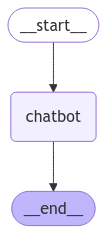

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Now let's run the chatbot! 

**Tip:** You can exit the chat loop at any time by typing "quit", "exit", or "q".

In [8]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: LangGraph is a library designed to help build stateful multi-agent applications using language models. It provides tools for creating workflows and state machines to coordinate multiple AI agents or language model interactions. LangGraph is built on top of LangChain, leveraging its components while adding graph-based coordination capabilities. It's particularly useful for developing more complex, stateful AI applications that go beyond simple query-response interactions.
Goodbye!


**Congratulations!** You've built your first chatbot using LangGraph. This bot can engage in basic conversation by taking user input and generating responses using an LLM. You can inspect a [LangSmith Trace](https://smith.langchain.com/public/7527e308-9502-4894-b347-f34385740d5a/r) for the call above at the provided link.

However, you may have noticed that the bot's knowledge is limited to what's in its training data. In the next part, we'll add a web search tool to expand the bot's knowledge and make it more capable.

Below is the full code for this section for your reference:

<details>
<summary>Full Code</summary>
    <pre>
        
```python
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")
graph = graph_builder.compile()
```

</pre>
</details>

## Part 2: 🛠️ Enhancing the Chatbot with Tools

To handle queries our chatbot can't answer "from memory", we'll integrate a web search tool. Our bot can use this tool to find relevant information and provide better responses.

#### Requirements

Before we start, make sure you have the necessary packages installed and API keys set up:

First, install the requirements to use the [Tavily Search Engine](https://python.langchain.com/docs/integrations/tools/tavily_search/), and set your [TAVILY_API_KEY](https://tavily.com/).

In [10]:
%%capture --no-stderr
%pip install -U tavily-python langchain_community

In [11]:
_set_env("TAVILY_API_KEY")

TAVILY_API_KEY:  ········


Next, define the tool:

In [11]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
  'content': 'Nodes: Nodes are the building blocks of your LangGraph. Each node represents a function or a computation step. You define nodes to perform specific tasks, such as processing input, making ...'},
 {'url': 'https://saksheepatil05.medium.com/demystifying-langgraph-a-beginner-friendly-dive-into-langgraph-concepts-5ffe890ddac0',
  'content': 'Nodes (Tasks): Nodes are like the workstations on the assembly line. Each node performs a specific task on the product. In LangGraph, nodes are Python functions that take the current state, do some work, and return an updated state. Next, we define the nodes, each representing a task in our sandwich-making process.'}]

The results are page summaries our chat bot can use to answer questions.


Next, we'll start defining our graph. The following is all **the same as in Part 1**, except we have added `bind_tools` on our LLM. This lets the LLM know the correct JSON format to use if it wants to use our search engine.

In [ ]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
# Modification: tell the LLM which tools it can call
# highlight-next-line
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

Next we need to create a function to actually run the tools if they are called. We'll do this by adding the tools to a new node.

Below, we implement a `BasicToolNode` that checks the most recent message in the state and calls tools if the message contains `tool_calls`. It relies on the LLM's `tool_calling` support, which is available in Anthropic, OpenAI, Google Gemini, and a number of other LLM providers.

We will later replace this with LangGraph's prebuilt [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode) to speed things up, but building it ourselves first is instructive.

In [ ]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

With the tool node added, we can define the `conditional_edges`. 

Recall that **edges** route the control flow from one node to the next. **Conditional edges** usually contain "if" statements to route to different nodes depending on the current graph state. These functions receive the current graph `state` and return a string or list of strings indicating which node(s) to call next.

Below, call define a router function called `route_tools`, that checks for tool_calls in the chatbot's output. Provide this function to the graph by calling `add_conditional_edges`, which tells the graph that whenever the `chatbot` node completes to check this function to see where to go next. 

The condition will route to `tools` if tool calls are present and `END` if not.

Later, we will replace this with the prebuilt [tools_condition](https://langchain-ai.github.io/langgraph/reference/prebuilt/#tools_condition) to be more concise, but implementing it ourselves first makes things more clear. 

In [14]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

**Notice** that conditional edges start from a single node. This tells the graph "any time the '`chatbot`' node runs, either go to 'tools' if it calls a tool, or end the loop if it responds directly. 

Like the prebuilt `tools_condition`, our function returns the `END` string if no tool calls are made. When the graph transitions to `END`, it has no more tasks to complete and ceases execution. Because the condition can return `END`, we don't need to explicitly set a `finish_point` this time. Our graph already has a way to finish!

Let's visualize the graph we've built. The following function has some additional dependencies to run that are unimportant for this tutorial.

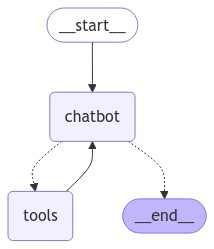

In [15]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Now we can ask the bot questions outside its training data.

In [16]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: [{'text': "To provide you with accurate and up-to-date information about LangGraph, I'll need to search for the latest details. Let me do that for you.", 'type': 'text'}, {'id': 'toolu_01Q588CszHaSvvP2MxRq9zRD', 'input': {'query': 'LangGraph AI tool information'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Assistant: [{"url": "https://www.langchain.com/langgraph", "content": "LangGraph sets the foundation for how we can build and scale AI workloads \u2014 from conversational agents, complex task automation, to custom LLM-backed experiences that 'just work'. The next chapter in building complex production-ready features with LLMs is agentic, and with LangGraph and LangSmith, LangChain delivers an out-of-the-box solution ..."}, {"url": "https://github.com/langchain-ai/langgraph", "content": "Overview. LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows. Compared to other LLM frameworks

**Congrats!** You've created a conversational agent in langgraph that can use a search engine to retrieve updated information when needed. Now it can handle a wider range of user queries. To inspect all the steps your agent just took, check out this [LangSmith trace](https://smith.langchain.com/public/4fbd7636-25af-4638-9587-5a02fdbb0172/r).

Our chatbot still can't remember past interactions on its own, limiting its ability to have coherent, multi-turn conversations. In the next part, we'll add **memory** to address this.


The full code for the graph we've created in this section is reproduced below, replacing our `BasicToolNode` for the prebuilt [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode), and our `route_tools` condition with the prebuilt [tools_condition](https://langchain-ai.github.io/langgraph/reference/prebuilt/#tools_condition)

<details>
<summary>Full Code</summary>
    <pre>

```python
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()
```

</pre>
</details>

## Part 3: Adding Memory to the Chatbot

Our chatbot can now use tools to answer user questions, but it doesn't remember the context of previous interactions. This limits its ability to have coherent, multi-turn conversations.

LangGraph solves this problem through **persistent checkpointing**. If you provide a `checkpointer` when compiling the graph and a `thread_id` when calling your graph, LangGraph automatically saves the state after each step. When you invoke the graph again using the same `thread_id`, the graph loads its saved state, allowing the chatbot to pick up where it left off. 

We will see later that **checkpointing** is _much_ more powerful than simple chat memory - it lets you save and resume complex state at any time for error recovery, human-in-the-loop workflows, time travel interactions, and more. But before we get too ahead of ourselves, let's add checkpointing to enable multi-turn conversations.

To get started, create a `MemorySaver` checkpointer.

In [18]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

**Notice** we're using an in-memory checkpointer. This is convenient for our tutorial (it saves it all in-memory). In a production application, you would likely change this to use `SqliteSaver` or `PostgresSaver` and connect to your own DB.

Next define the graph. Now that you've already built your own `BasicToolNode`, we'll replace it with LangGraph's prebuilt `ToolNode` and `tools_condition`, since these do some nice things like parallel API execution. Apart from that, the following is all copied from Part 2.

In [ ]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

Finally, compile the graph with the provided checkpointer.

In [23]:
graph = graph_builder.compile(checkpointer=memory)

Notice the connectivity of the graph hasn't changed since Part 2. All we are doing is checkpointing the `State` as the graph works through each node.

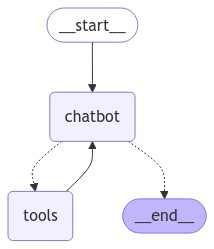

In [21]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Now you can interact with your bot! First, pick a thread to use as the key for this conversation.

In [22]:
config = {"configurable": {"thread_id": "1"}}

Next, call your chat bot.

In [23]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hello Will! It's nice to meet you. How can I assist you today? Is there anything specific you'd like to know or discuss?


**Note:** The config was provided as the **second positional argument** when calling our graph. It importantly is _not_ nested within the graph inputs (`{'messages': []}`).

Let's ask a followup: see if it remembers your name.

In [24]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Of course, I remember your name, Will. I always try to pay attention to important details that users share with me. Is there anything else you'd like to talk about or any questions you have? I'm here to help with a wide range of topics or tasks.


**Notice** that we aren't using an external list for memory: it's all handled by the checkpointer! You can inspect the full execution in this [LangSmith trace](https://smith.langchain.com/public/29ba22b5-6d40-4fbe-8d27-b369e3329c84/r) to see what's going on.

Don't believe me? Try this using a different config.

In [25]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    # highlight-next-line
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I apologize, but I don't have any previous context or memory of your name. As an AI assistant, I don't retain information from past conversations. Each interaction starts fresh. Could you please tell me your name so I can address you properly in this conversation?


**Notice** that the **only** change we've made is to modify the `thread_id` in the config. See this call's [LangSmith trace](https://smith.langchain.com/public/51a62351-2f0a-4058-91cc-9996c5561428/r) for comparison. 

By now, we have made a few checkpoints across two different threads. But what goes into a checkpoint? To inspect a graph's `state` for a given config at any time, call `get_state(config)`.

In [26]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='8c1ca919-c553-4ebf-95d4-b59a2d61e078'), AIMessage(content="Hello Will! It's nice to meet you. How can I assist you today? Is there anything specific you'd like to know or discuss?", additional_kwargs={}, response_metadata={'id': 'msg_01WTQebPhNwmMrmmWojJ9KXJ', 'model': 'claude-3-5-sonnet-20240620', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 405, 'output_tokens': 32}}, id='run-58587b77-8c82-41e6-8a90-d62c444a261d-0', usage_metadata={'input_tokens': 405, 'output_tokens': 32, 'total_tokens': 437}), HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='daba7df6-ad75-4d6b-8057-745881cea1ca'), AIMessage(content="Of course, I remember your name, Will. I always try to pay attention to important details that users share with me. Is there anything else you'd like to talk about or any questions yo

In [27]:
snapshot.next  # (since the graph ended this turn, `next` is empty. If you fetch a state from within a graph invocation, next tells which node will execute next)

()

The snapshot above contains the current state values, corresponding config, and the `next` node to process. In our case, the graph has reached an `END` state, so `next` is empty.

**Congratulations!** Your chatbot can now maintain conversation state across sessions thanks to LangGraph's checkpointing system. This opens up exciting possibilities for more natural, contextual interactions. LangGraph's checkpointing even handles **arbitrarily complex graph states**, which is much more expressive and powerful than simple chat memory.

In the next part, we'll introduce human oversight to our bot to handle situations where it may need guidance or verification before proceeding.
  
Check out the code snippet below to review our graph from this section.

<details>
<summary>Full Code</summary>
    <pre>

```python
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)
```
</pre>
</pre>
</details>

## Part 4: Human-in-the-loop

Agents can be unreliable and may need human input to successfully accomplish tasks. Similarly, for some actions, you may want to require human approval before running to ensure that everything is running as intended.

LangGraph's [persistence](../../concepts/persistence) layer supports human-in-the-loop workflows, allowing execution to pause and resume based on user feedback. The primary interface to this functionality is the [interrupt](../../concepts/human_in_the_loop/#interrupt) function. Calling `interrupt` inside a node will pause execution. Execution can be resumed, together with new input from a human, by passing in a [Command](../../concepts/human_in_the_loop/#the-command-primitive). `interrupt` is ergonomically similar to Python's built-in `input()`, [with some caveats](../../concepts/human_in_the_loop/#interrupt). We demonstrate an example below.

First, start with our existing code from Part 3. We will make one change, which is to add a simple `human_assistance` tool accessible to the chatbot. This tool uses `interrupt` to receive information from a human.

In [ ]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

# highlight-next-line
from langgraph.types import Command, interrupt


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


# highlight-next-line
@tool
# highlight-next-line
def human_assistance(query: str) -> str:
    # highlight-next-line
    """Request assistance from a human."""
    # highlight-next-line
    human_response = interrupt({"query": query})
    # highlight-next-line
    return human_response["data"]


tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

------

!!! tip

    Check out the [Human-in-the-loop section](../../how-tos/#human-in-the-loop) of the How-to Guides for more examples of Human-in-the-loop workflows, including how to [review and edit tool calls](../../how-tos/human_in_the_loop/review-tool-calls/) before they are executed.

---------

We compile the graph with a checkpointer, as before:

In [2]:
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

Visualizing the graph, we recover the same layout as before. We have just added a tool!

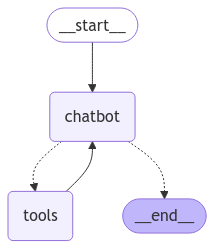

In [3]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Let's now prompt the chatbot with a question that will engage the new `human_assistance` tool:

In [4]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================

[{'text': "Certainly! I'd be happy to request expert assistance for you regarding building an AI agent. To do this, I'll use the human_assistance function to relay your request. Let me do that for you now.", 'type': 'text'}, {'id': 'toolu_01ABUqneqnuHNuo1vhfDFQCW', 'input': {'query': 'A user is requesting expert guidance for building an AI agent. Could you please provide some expert advice or resources on this topic?'}, 'name': 'human_assistance', 'type': 'tool_use'}]
Tool Calls:
  human_assistance (toolu_01ABUqneqnuHNuo1vhfDFQCW)
 Call ID: toolu_01ABUqneqnuHNuo1vhfDFQCW
  Args:
    query: A user is requesting expert guidance for building an AI agent. Could you please provide some expert advice or resources on this topic?


The chatbot generated a tool call, but then execution has been interrupted! Note that if we inspect the graph state, we see that it stopped at the tools node:

In [5]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

Let's take a closer look at the `human_assistance` tool:

```python
@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]
```

Similar to Python's built-in `input()` function, calling `interrupt` inside the tool will pause execution. Progress is persisted based on our choice of [checkpointer](../../concepts/persistence/#checkpointer-libraries)-- so if we are persisting with Postgres, we can resume at any time as long as the database is alive. Here we are persisting with the in-memory checkpointer, so we can resume any time as long as our Python kernel is running.

To resume execution, we pass a [Command](../../concepts/human_in_the_loop/#the-command-primitive) object containing data expected by the tool. The format of this data can be customized based on our needs. Here, we just need a dict with a key `"data"`:

In [6]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

[{'text': "Certainly! I'd be happy to request expert assistance for you regarding building an AI agent. To do this, I'll use the human_assistance function to relay your request. Let me do that for you now.", 'type': 'text'}, {'id': 'toolu_01ABUqneqnuHNuo1vhfDFQCW', 'input': {'query': 'A user is requesting expert guidance for building an AI agent. Could you please provide some expert advice or resources on this topic?'}, 'name': 'human_assistance', 'type': 'tool_use'}]
Tool Calls:
  human_assistance (toolu_01ABUqneqnuHNuo1vhfDFQCW)
 Call ID: toolu_01ABUqneqnuHNuo1vhfDFQCW
  Args:
    query: A user is requesting expert guidance for building an AI agent. Could you please provide some expert advice or resources on this topic?
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build

Our input has been received and processed as a tool message. Review this call's [LangSmith trace](https://smith.langchain.com/public/9f0f87e3-56a7-4dde-9c76-b71675624e91/r) to see the exact work that was done in the above call. Notice that the state is loaded in the first step so that our chatbot can continue where it left off.

**Congrats!** You've used an `interrupt` to add human-in-the-loop execution to your chatbot, allowing for human oversight and intervention when needed. This opens up the potential UIs you can create with your AI systems. Since we have already added a **checkpointer**, as long as the underlying persistence layer is running, the graph can be paused **indefinitely** and resumed at any time as if nothing had happened.

Human-in-the-loop workflows enable a variety of new workflows and user experiences. Check out [this section](../../how-tos/#human-in-the-loop) of the How-to Guides for more examples of Human-in-the-loop workflows, including how to [review and edit tool calls](../../how-tos/human_in_the_loop/review-tool-calls/) before they are executed.


<details>
<summary>Full Code</summary>
    <pre>

```python
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]


tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert(len(message.tool_calls) <= 1)
    return {"messages": [message]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)
```
</pre>
</details>

## Part 5: Customizing State

So far, we've relied on a simple state with one entry-- a list of messages. You can go far with this simple state, but if you want to define complex behavior without relying on the message list, you can add additional fields to the state. Here we will demonstrate a new scenario, in which the chatbot is using its search tool to find specific information, and forwarding them to a human for review. Let's have the chatbot research the birthday of an entity. We will add `name` and `birthday` keys to the state:

In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # highlight-next-line
    name: str
    # highlight-next-line
    birthday: str

Adding this information to the state makes it easily accessible by other graph nodes (e.g., a downstream node that stores or processes the information), as well as the graph's persistence layer.

Here, we will populate the state keys inside of our `human_assistance` tool. This allows a human to review the information before it is stored in the state. We will again use `Command`, this time to issue a state update from inside our tool. Read more about use cases for `Command` [here](../../concepts/low_level/#using-inside-tools).

In [3]:
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool

from langgraph.types import Command, interrupt


@tool
# Note that because we are generating a ToolMessage for a state update, we
# generally require the ID of the corresponding tool call. We can use
# LangChain's InjectedToolCallId to signal that this argument should not
# be revealed to the model in the tool's schema.
def human_assistance(
    name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """Request assistance from a human."""
    human_response = interrupt(
        {
            "question": "Is this correct?",
            "name": name,
            "birthday": birthday,
        },
    )
    # If the information is correct, update the state as-is.
    if human_response.get("correct", "").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "Correct"
    # Otherwise, receive information from the human reviewer.
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"

    # This time we explicitly update the state with a ToolMessage inside
    # the tool.
    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }
    # We return a Command object in the tool to update our state.
    return Command(update=state_update)

Otherwise, the rest of our graph is the same:

In [4]:
from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition


tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}


graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

Let's prompt our application to look up the "birthday" of the LangGraph library. We will direct the chatbot to reach out to the `human_assistance` tool once it has the required information. Note that setting `name` and `birthday` in the arguments for the tool, we force the chatbot to generate proposals for these fields.

In [5]:
user_input = (
    "Can you look up when LangGraph was released? "
    "When you have the answer, use the human_assistance tool for review."
)
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up when LangGraph was released? When you have the answer, use the human_assistance tool for review.
================================== Ai Message ==================================

[{'text': "Certainly! I'll start by searching for information about LangGraph's release date using the Tavily search function. Then, I'll use the human_assistance tool for review.", 'type': 'text'}, {'id': 'toolu_01JoXQPgTVJXiuma8xMVwqAi', 'input': {'query': 'LangGraph release date'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_01JoXQPgTVJXiuma8xMVwqAi)
 Call ID: toolu_01JoXQPgTVJXiuma8xMVwqAi
  Args:
    query: LangGraph release date
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://blog.langchain.dev/langgraph-cloud/", "content": "We also have a new stable release of L

We've hit the `interrupt` in the `human_assistance` tool again. In this case, the chatbot failed to identify the correct date, so we can supply it:

In [6]:
human_command = Command(
    resume={
        "name": "LangGraph",
        "birthday": "Jan 17, 2024",
    },
)

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

[{'text': "Based on the search results, it appears that LangGraph was already in existence before June 27, 2024, when LangGraph Cloud was announced. However, the search results don't provide a specific release date for the original LangGraph. \n\nGiven this information, I'll use the human_assistance tool to review and potentially provide more accurate information about LangGraph's initial release date.", 'type': 'text'}, {'id': 'toolu_01JDQAV7nPqMkHHhNs3j3XoN', 'input': {'name': 'Assistant', 'birthday': '2023-01-01'}, 'name': 'human_assistance', 'type': 'tool_use'}]
Tool Calls:
  human_assistance (toolu_01JDQAV7nPqMkHHhNs3j3XoN)
 Call ID: toolu_01JDQAV7nPqMkHHhNs3j3XoN
  Args:
    name: Assistant
    birthday: 2023-01-01
================================= Tool Message =================================
Name: human_assistance

Made a correction: {'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}
=============

Note that these fields are now reflected in the state:

In [7]:
snapshot = graph.get_state(config)

{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}

{'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}

This makes them easily accessible to downstream nodes (e.g., a node that further processes or stores the information).

### Manually updating state

LangGraph gives a high degree of control over the application state. For instance, at any point (including when interrupted), we can manually override a key using `graph.update_state`:

In [8]:
graph.update_state(config, {"name": "LangGraph (library)"})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd4ec5-cf69-6352-8006-9278f1730162'}}

If we call `graph.get_state`, we can see the new value is reflected:

In [9]:
snapshot = graph.get_state(config)

{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}

{'name': 'LangGraph (library)', 'birthday': 'Jan 17, 2024'}

Manual state updates will even [generate a trace](https://smith.langchain.com/public/7ebb7827-378d-49fe-9f6c-5df0e90086c8/r) in LangSmith. If desired, they can also be used to control human-in-the-loop workflows, as described in [this guide](../../how-tos/human_in_the_loop/edit-graph-state/). Use of the `interrupt` function is generally recommended instead, as it allows data to be transmitted in a human-in-the-loop interaction independently of state updates.

**Congratulations!** You've added custom keys to the state to facilitate a more complex workflow, and learned how to generate state updates from inside tools.

We're almost done with the tutorial, but there is one more concept we'd like to review before finishing that connects `checkpointing` and `state updates`. 

This section's code is reproduced below for your reference.


<details>
<summary>Full Code</summary>
    <pre>

```python
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt



class State(TypedDict):
    messages: Annotated[list, add_messages]
    name: str
    birthday: str


@tool
def human_assistance(
    name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """Request assistance from a human."""
    human_response = interrupt(
        {
            "question": "Is this correct?",
            "name": name,
            "birthday": birthday,
        },
    )
    if human_response.get("correct", "").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "Correct"
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"

    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }
    return Command(update=state_update)


tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert(len(message.tool_calls) <= 1)
    return {"messages": [message]}


graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)
```
</pre>
</details>

## Part 6: Time Travel

In a typical chat bot workflow, the user interacts with the bot 1 or more times to accomplish a task. In the previous sections, we saw how to add memory and a human-in-the-loop to be able to checkpoint our graph state and control future responses.

But what if you want to let your user start from a previous response and "branch off" to explore a separate outcome? Or what if you want users to be able to "rewind" your assistant's work to fix some mistakes or try a different strategy (common in applications like autonomous software engineers)?

You can create both of these experiences and more using LangGraph's built-in "time travel" functionality. 

In this section, you will "rewind" your graph by fetching a checkpoint using the graph's `get_state_history` method. You can then resume execution at this previous point in time.

For this, let's use the simple chatbot with tools from [Part 3](#part-3-adding-memory-to-the-chatbot):

In [10]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

Let's have our graph take a couple steps. Every step will be checkpointed in its state history:

In [11]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "I'm learning LangGraph. "
                    "Could you do some research on it for me?"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================

[{'text': "Certainly! I'd be happy to research LangGraph for you. To get the most up-to-date and accurate information, I'll use the Tavily search engine to look this up. Let me do that for you now.", 'type': 'text'}, {'id': 'toolu_01BscbfJJB9EWJFqGrN6E54e', 'input': {'query': 'LangGraph latest information and features'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_01BscbfJJB9EWJFqGrN6E54e)
 Call ID: toolu_01BscbfJJB9EWJFqGrN6E54e
  Args:
    query: LangGraph latest information and features
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://blockchain.news/news/langchain-new-features-upcoming-events-update", "content": 

In [12]:
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "Ya that's helpful. Maybe I'll "
                    "build an autonomous agent with it!"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================

[{'text': "That's an exciting idea! Building an autonomous agent with LangGraph is indeed a great application of this technology. LangGraph is particularly well-suited for creating complex, multi-step AI workflows, which is perfect for autonomous agents. Let me gather some more specific information about using LangGraph for building autonomous agents.", 'type': 'text'}, {'id': 'toolu_01QWNHhUaeeWcGXvA4eHT7Zo', 'input': {'query': 'Building autonomous agents with LangGraph examples and tutorials'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_01QWNHhUaeeWcGXvA4eHT7Zo)
 Call ID: toolu_01QWNHhUaeeWcGXvA4eHT7Zo
  Args:
    query: Building autonomous agents with LangGraph examples and tutorials
===========

Now that we've had the agent take a couple steps, we can `replay` the full state history to see everything that occurred.

In [13]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 6:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  8 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  7 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  6 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  1 Next:  ('chatbot',)
-----------------------------------------

**Notice** that checkpoints are saved for every step of the graph. This __spans invocations__ so you can rewind across a full thread's history. We've picked out `to_replay` as a state to resume from. This is the state after the `chatbot` node in the second graph invocation above.

Resuming from this point should call the **action** node next.

In [14]:
print(to_replay.next)
print(to_replay.config)

('tools',)
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efd43e3-0c1f-6c4e-8006-891877d65740'}}


**Notice** that the checkpoint's config (`to_replay.config`) contains a `checkpoint_id` **timestamp**. Providing this `checkpoint_id` value tells LangGraph's checkpointer to **load** the state from that moment in time. Let's try it below:

In [15]:
# The `checkpoint_id` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

[{'text': "That's an exciting idea! Building an autonomous agent with LangGraph is indeed a great application of this technology. LangGraph is particularly well-suited for creating complex, multi-step AI workflows, which is perfect for autonomous agents. Let me gather some more specific information about using LangGraph for building autonomous agents.", 'type': 'text'}, {'id': 'toolu_01QWNHhUaeeWcGXvA4eHT7Zo', 'input': {'query': 'Building autonomous agents with LangGraph examples and tutorials'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_01QWNHhUaeeWcGXvA4eHT7Zo)
 Call ID: toolu_01QWNHhUaeeWcGXvA4eHT7Zo
  Args:
    query: Building autonomous agents with LangGraph examples and tutorials
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://towardsdatascience.com/bu

Notice that the graph resumed execution from the `**action**` node. You can tell this is the case since the first value printed above is the response from our search engine tool.

**Congratulations!** You've now used time-travel checkpoint traversal in LangGraph. Being able to rewind and explore alternative paths opens up a world of possibilities for debugging, experimentation, and interactive applications.

## Next Steps

Take your journey further by exploring deployment and advanced features:

### Server Quickstart

- **[LangGraph Server Quickstart](../langgraph-platform/local-server)**: Launch a LangGraph server locally and interact with it using the REST API and LangGraph Studio Web UI.

### LangGraph Cloud

- **[LangGraph Cloud QuickStart](../../cloud/quick_start)**: Deploy your LangGraph app using LangGraph Cloud.

### LangGraph Framework

- **[LangGraph Concepts](../../concepts)**: Learn the foundational concepts of LangGraph.  
- **[LangGraph How-to Guides](../../how-tos)**: Guides for common tasks with LangGraph.

### LangGraph Platform

Expand your knowledge with these resources:

- **[LangGraph Platform Concepts](../../concepts#langgraph-platform)**: Understand the foundational concepts of the LangGraph Platform.  
- **[LangGraph Platform How-to Guides](../../how-tos#langgraph-platform)**: Guides for common tasks with LangGraph Platform. 